In [1]:
import numpy as np # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt
fs = 256
import pymultifracs.mfa as mfa
from pymultifracs.utils import build_q_log
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
from CogBeacon_PlotUtils import *
from CogBeaconDataset import CogBeaconDataset

cogbeacon_root_path = '/Users/athenasaghi/VSProjects/CognitiveFatigueDetection/CogFatigueData/CogBeacon/'
dataset = CogBeaconDataset(cogbeacon_root_path)

In [51]:
def loadData(user_id = [1], session_day = ['First'], game_mode=['m'] , channel = "AF8"):
    # user_id = [str(i) for i in range(20) if i not in (8, 18)] 
    eegData=[]
    fatigueLabels = []
    for session in session_day:
        for user in user_id:
            for mode in game_mode:
                participant_data_per_turn , participant_labels = dataset.load_session_by_participant(user, session,mode,channel)
                eegData.append(participant_data_per_turn)
            fatigueLabels.append(participant_labels)
    return eegData , fatigueLabels 

# eegData , fatigueLabels = loadData(user_id= [str(i) for i in range(20) if i not in (8, 18)], channel="AF7")

In [208]:
q = build_q_log(1,15,10)
q

array([-15.        , -11.10233819,  -8.21746089,  -6.082202  ,
        -4.50177757,  -3.33201714,  -2.46621207,  -2.        ,
        -1.82538137,  -1.35106675,  -1.        ,  -0.        ,
         1.        ,   1.35106675,   1.82538137,   2.        ,
         2.46621207,   3.33201714,   4.50177757,   6.082202  ,
         8.21746089,  11.10233819,  15.        ])

session loaded successfully {'user_id': '0', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120
session loaded successfully {'user_id': '1', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120
session loaded successfully {'user_id': '2', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 80
session loaded successfully {'user_id': '3', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120
session loaded successfully {'user_id': '4', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120
session loaded successfully {'user_id': '5', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120
session loaded successfully {'user_id': '6', 's

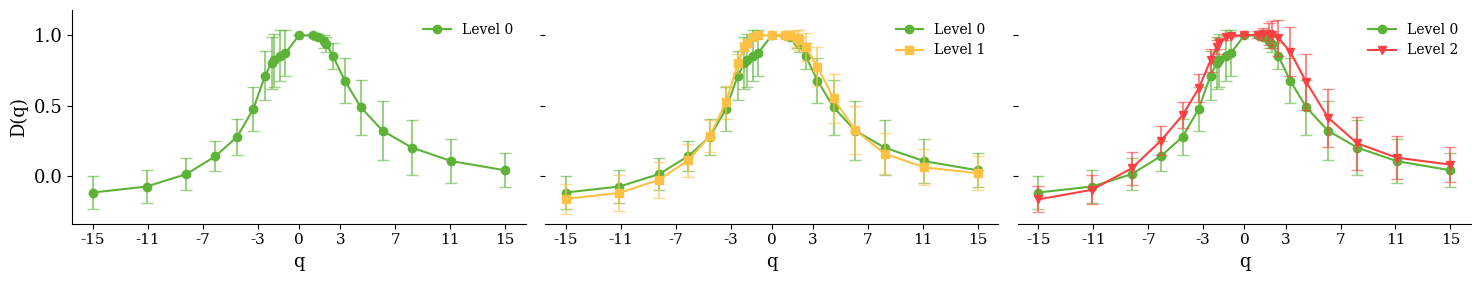

In [209]:

from scipy.stats import t

def Dq(X):
    dwt, lwt = mfa.mf_analysis_full(
        X,
        scaling_ranges=[[1, 8]],
        # q=list(range(-15,17,2)),  # Ensure 41 values
        q = build_q_log(1,15,10),
        n_cumul=8,
        p_exp=np.inf,
        gamint=0,
        weighted=None
    )
    
    lwt_sf, lwt_cumul, lwt_mfs, hmin = lwt
    return lwt_mfs.Dq.squeeze(), lwt_mfs.q  # Ensure Dq is 1D

def average_Dq(Dq_list):
    """
    Compute the average and confidence interval for a list of Dq arrays.
    Returns mean, lower bound, and upper bound of the confidence interval.
    """
    Dq_array = np.array(Dq_list)  # Convert list to NumPy array
    mean_Dq = np.mean(Dq_array, axis=0)  # Compute mean
    std_Dq = np.std(Dq_array, axis=0, ddof=1)  # Compute standard deviation
    n = Dq_array.shape[0]  # Number of samples

    # Compute 95% confidence interval using t-distribution
    confidence = 0.90
    dof = n - 1  # Degrees of freedom
    t_critical = t.ppf((1 + confidence) / 2, dof) if n > 1 else 0  # Avoid error when n=1
    margin_of_error = t_critical * (std_Dq / np.sqrt(n)) if n > 1 else np.zeros_like(mean_Dq)

    lower_bound = mean_Dq - margin_of_error
    upper_bound = mean_Dq + margin_of_error

    return mean_Dq.reshape(1, -1), lower_bound.reshape(1, -1), upper_bound.reshape(1, -1)

def process_eeg_data_all(eegData, fatigueLabels, function_f):
    fatigue_grouped_Dq = {}

    for participant_eeg, participant_labels in zip(eegData, fatigueLabels):
        label_groups = {}
        for eeg_segment, label in zip(participant_eeg, participant_labels):
            if label not in label_groups:
                label_groups[label] = []
            label_groups[label].append(eeg_segment)

        # Compute Dq for each label
        for label, data_group in label_groups.items():
            Dq_values, q_values = function_f(np.concatenate(data_group))
            if label not in fatigue_grouped_Dq:
                fatigue_grouped_Dq[label] = []
            fatigue_grouped_Dq[label].append(Dq_values)

    # Compute the average Dq and confidence intervals for each fatigue label
    avg_Dq_per_fatigue = {
        label: (*average_Dq(Dq_list), q_values) for label, Dq_list in fatigue_grouped_Dq.items()
    }

    return avg_Dq_per_fatigue


# def plot_Dq(results):
    # plt.figure(figsize=(4,3))  # More square aspect ratio
    plt.figure(figsize=(7,4))  # More square aspect ratio

    

    plt.rcParams.update({
    'font.family': 'serif',  # Options: 'sans-serif', 'serif', 'monospace', etc.
    'font.size': 13, })
    
    # Use a single-shade colormap
    # colors = plt.cm.Blues(np.linspace(0.3, 1, len(results)))
    colors = ['#FF1F5A', '#FFD615', '#1E2A78']
    markers = ['o', 's','v','x', 'd', '^', 'p', 'h' , '+']
    for i, (label, (mean_Dq, lower_CI, upper_CI, q_values)) in enumerate(results.items()):
      if label <1:
        half_idx = 0
        q_values_half = q_values[half_idx:]
        mean_Dq_half = mean_Dq.reshape(-1)[half_idx:]
        lower_CI_half = lower_CI.reshape(-1)[half_idx:]
        upper_CI_half = upper_CI.reshape(-1)[half_idx:]
        ci_range = upper_CI_half - lower_CI_half
        # Plot mean curve
        plt.plot(q_values_half, mean_Dq_half, 's-', label=f'L {label}')

        # Plot confidence interval as a shaded area
        # plt.fill_between(q_values_half, lower_CI_half, upper_CI_half, color=colors[i], alpha=0.3)
        plt.errorbar(q_values_half, mean_Dq_half, yerr=ci_range / 2, fmt='none', capsize=4, capthick=1, alpha=0.7)


    plt.xlabel('q')
    plt.ylabel('D(q)')
    plt.spines['top'].set_visible(False)
    plt.spines['right'].set_visible(False)
    plt.xticks(fontsize=12)
    # plt.title('Multifractal Spectrum (Dq vs q) - Second Half', fontsize=14)

    # Ensure x-axis shows the exact q values
    plt.xticks(q_values_half, labels=[str(q) for q in q_values_half])

    # Customize the legend (remove box)
    plt.legend(fontsize=12, frameon=False, loc = 'upper left')
    plt.savefig("example1-2", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_Dq(results):
    fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True)

    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 13,
    })

    colors = ['#5CB338', '#FFC145', '#FB4141']  # Level 0, 1, 2 (orange instead of yellow)
    markers = ['o', 's', 'v']
    plot_levels = [[0], [0, 1], [0, 2]]
    selected_q_ticks = [-15,-11,-7, -3,0,3, 7, 11,15]
    # selected_q_ticks = [-10, -8,-6, -2,0, 2,4, 6,8,10]

    for idx, levels in enumerate(plot_levels):
        ax = axs[idx]
        for l in levels:
            if l not in results:
                continue
            mean_Dq, lower_CI, upper_CI, q_values = results[l]
            q_values = np.array(q_values)
            mean_Dq = np.array(mean_Dq).reshape(-1)
            lower_CI = np.array(lower_CI).reshape(-1)
            upper_CI = np.array(upper_CI).reshape(-1)

            half_idx = 0
            q_half = q_values[half_idx:]
            mean_half = mean_Dq[half_idx:]
            lower_half = lower_CI[half_idx:]
            upper_half = upper_CI[half_idx:]
            ci_range = upper_half - lower_half
            ax.plot(q_half, mean_half,
                    marker=markers[l],
                    linestyle='-',
                    label=f'Level {l}',
                    color=colors[l])
            ax.errorbar(q_half, mean_half, yerr=ci_range / 2,
                        fmt='none', capsize=4, capthick=1, alpha=0.6, color=colors[l])

        ax.set_xlabel('q')
        if idx == 0:
            ax.set_ylabel('D(q)')

        # Show only selected q-ticks
        ax.set_xticks(selected_q_ticks)
        ax.set_xticklabels([str(q) for q in selected_q_ticks], fontsize=11)

        # Only show left spine for first plot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if idx != 0:
            ax.spines['left'].set_visible(False)
            # ax.set_yticks([])

        # Keep bottom spine visible for all
        ax.spines['bottom'].set_visible(True)
        # ax.set_title(f'Plot {idx + 1}', fontsize=12)
        ax.legend(fontsize=10, frameon=False)

    plt.tight_layout()
    plt.savefig("side_by_side_plots_updated_TP9.png", dpi=300, bbox_inches='tight')
    plt.show()


eegData , fatigueLabels = loadData(user_id= [str(i) for i in range(0,19) if i not in (12, 18)], channel="TP9", session_day = ['First'])
avg_Dq_results = process_eeg_data_all(eegData, fatigueLabels, Dq)
plot_Dq(avg_Dq_results)


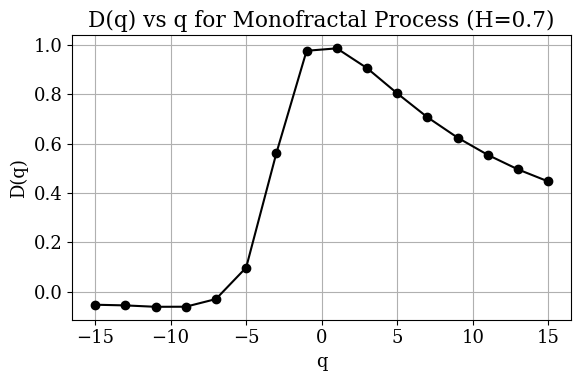

In [203]:
import numpy as np
import matplotlib.pyplot as plt

# Generate monofractal signal (e.g., fractional Brownian motion with H = 0.7)
def generate_fbm(n=1024, H=0.7):
    from fbm import FBM
    f = FBM(n=n-1, hurst=H, length=1, method='daviesharte')
    return f.fbm()

# Generate monofractal signal
X = generate_fbm(n=2048, H=0.75)


def Dq(X):
    dwt, lwt = mfa.mf_analysis_full(
        X,
        scaling_ranges=[[1, 7]],
        q=list(range(-15,17,2)),  # Ensure 41 values
        # q = build_q_log(1, 10, 10),
        n_cumul=8,
        p_exp=np.inf,
        gamint=0,
        weighted=None
    )
    
    lwt_sf, lwt_cumul, lwt_mfs, hmin = lwt
    return lwt_mfs.Dq.squeeze(), lwt_mfs.q  # Ensure Dq is 1D

Dq_vals, q_vals = Dq(X)

# Plot D(q) vs q
plt.figure(figsize=(6, 4))
plt.plot(q_vals, Dq_vals, marker='o', color='black')
plt.xlabel('q')
plt.ylabel('D(q)')
plt.title('D(q) vs q for Monofractal Process (H=0.7)')
plt.grid(True)
plt.tight_layout()
plt.show()


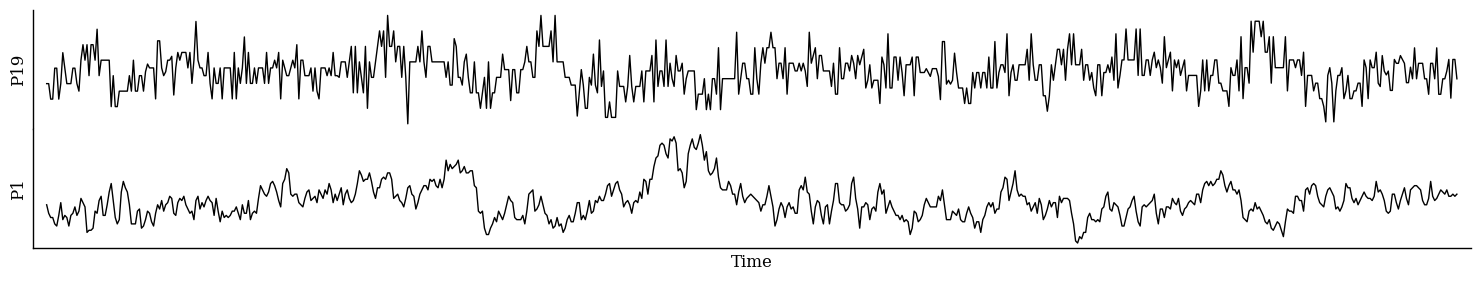

In [93]:
import matplotlib.pyplot as plt

x = np.linspace(0, 100, 700)
y = eegData[16][0][0:700]
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y2 = eegData[0][0][0:700]
y2 = (y2 - np.min(y2)) / (np.max(y2) - np.min(y2))

fig, axs = plt.subplots(2, 1, figsize=(15, 3), sharex=True, gridspec_kw={'hspace': 0})

for ax, y in zip(axs, [y, y2]):
    ax.plot(x, y, color='black', linewidth=1)
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

axs[1].spines['bottom'].set_visible(True)
axs[0].spines['bottom'].set_visible(False)
axs[1].set_xticks([])  # optionally hide x-ticks here too
axs[1].set_xlabel('Time', fontsize=12)
axs[1].set_xlim(-1, 101)
axs[0].set_ylabel('P19', fontsize=12)
axs[1].set_ylabel('P1', fontsize=12)
plt.tight_layout()
plt.savefig("dataraw", dpi=600, bbox_inches='tight') 
plt.show()

(16,)
(4, 4)


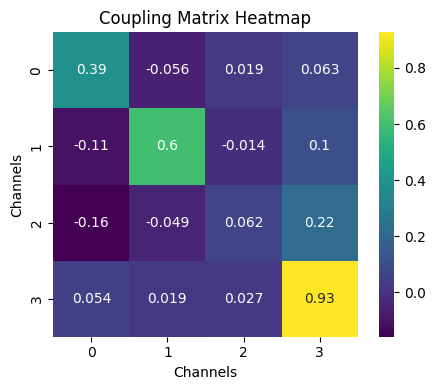

In [22]:
from mne_connectivity.viz import plot_connectivity_circle

# Assuming you have labels and a symmetric coupling matrix
# labels = [f'Ch{i}' for i in range(10)]  # adjust size
# sample = couplingmatrices[10]
# plot_connectivity_circle(sample[:10, :10], labels, title='Coupling Connectivity', show=True)


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sample = couplingmatrices[16][1]

sample = np.array(sample)
print(sample.shape)
sample = sample.reshape(4, 4)
print(sample.shape)
plt.figure(figsize=(5, 4))
sns.heatmap(sample, cmap='viridis', square=True,annot=True)
plt.title('Coupling Matrix Heatmap')
plt.xlabel('Channels')
plt.ylabel('Channels')
plt.savefig("As_heatmap_19", dpi=300,transparent=True, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [10]:
len(couplingmatrices[16])

202

In [3]:
import pandas as pd
df = pd.read_pickle('/Users/athenasaghi/VSProjects/CognitiveFatigueDetection/processed_data_full.pkl')
couplingmatrices= df['features'].tolist()

In [50]:
eegData , fatigueLabels = loadData(user_id= [str(i) for i in range(20) if i not in (12, 18)], channel="TP10", session_day = ['First'])

avg_Dq_results = process_eeg_data_all(eegData, fatigueLabels, Dq)
# plot_Dq(avg_Dq_results)

from scipy.stats import wasserstein_distance

def compute_wasserstein_distances_filtered(avg_Dq_results, target_labels=[0, 1, 2]):
    """
    Computes the Wasserstein distance between each pair of Dq distributions for the specified labels only.
    Returns a dictionary with tuple keys representing label pairs and their respective distances.
    """
    available_labels = sorted(set(avg_Dq_results.keys()) & set(target_labels))  # Filter labels
    wasserstein_distances = {}

    for i in range(len(available_labels)):
        for j in range(i + 1, len(available_labels)):  # Avoid duplicate pairs
            label1, label2 = available_labels[i], available_labels[j]
            Dq1 = avg_Dq_results[label1][0].flatten()  # Mean Dq for label1
            Dq2 = avg_Dq_results[label2][0].flatten()  # Mean Dq for label2
            
            distance = wasserstein_distance(Dq1, Dq2)
            wasserstein_distances[(label1, label2)] = distance

    return wasserstein_distances

wasserstein_results_filtered = compute_wasserstein_distances_filtered(avg_Dq_results, target_labels=[0, 1, 2])

for (label1, label2), distance in wasserstein_results_filtered.items():
    print(f"Wasserstein Distance between Fatigue {label1} and Fatigue {label2}: {distance:.4f}")


import matplotlib.pyplot as plt

def plot_wasserstein_bar(wasserstein_results):
    """
    Plots a bar chart of Wasserstein distances between fatigue labels.
    """
    pairs = [f"{label1} vs {label2}" for (label1, label2) in wasserstein_results.keys()]
    distances = list(wasserstein_results.values())

    plt.figure(figsize=(7, 5))

    colors = ['#ffa5ab', '#da627d', '#a53860']  # Blue, Green, Orange

    bars = plt.bar(pairs, distances, color=colors[:len(pairs)], width=0.4)  # Reduce bar width

    for bar in bars:
        yval = bar.get_height()
        # plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.3f}", ha='center', va='bottom', fontsize=10)

    plt.xlabel("Fatigue Level Pairs",fontsize=16)
    plt.ylabel("Wasserstein Distance",fontsize=16)
    plt.xticks(ha="center" )  # Rotate labels for better readability
    plt.savefig("was_dis_TP10_v1", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# Call the function
plot_wasserstein_bar(wasserstein_results_filtered)


session loaded successfully {'user_id': '0', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120
session loaded successfully {'user_id': '1', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120
session loaded successfully {'user_id': '2', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 80
session loaded successfully {'user_id': '3', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120
session loaded successfully {'user_id': '4', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120
session loaded successfully {'user_id': '5', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120
session loaded successfully {'user_id': '6', 's

KeyboardInterrupt: 

session loaded successfully {'user_id': '0', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '1', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '2', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '3', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '4', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '5', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': 

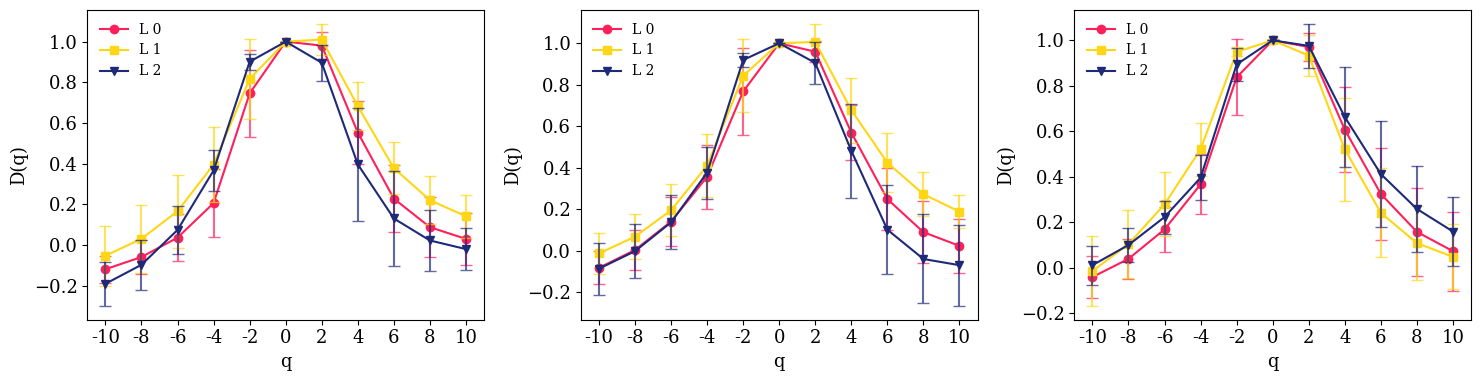

In [380]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t

def plot_Dq_subplot(ax, results, title):
    colors = ['#FF1F5A', '#FFD615', '#1E2A78']
    markers = ['o', 's', 'v', 'x', 'd', '^', 'p', 'h', '+']
    
    for i, (label, (mean_Dq, lower_CI, upper_CI, q_values)) in enumerate(results.items()):
        if label < 3:
            half_idx = 0
            q_values_half = q_values[half_idx:]
            mean_Dq_half = mean_Dq.reshape(-1)[half_idx:]
            lower_CI_half = lower_CI.reshape(-1)[half_idx:]
            upper_CI_half = upper_CI.reshape(-1)[half_idx:]
            ci_range = upper_CI_half - lower_CI_half
            
            ax.plot(q_values_half, mean_Dq_half, 's-', label=f'L {label}', color=colors[i], marker=markers[i])
            ax.errorbar(q_values_half, mean_Dq_half, yerr=ci_range / 2, fmt='none', ecolor=colors[i], capsize=4, capthick=1, alpha=0.7)
    
    ax.set_xlabel('q')
    ax.set_ylabel('D(q)')
    ax.set_xticks(q_values_half)
    ax.set_xticklabels([str(q) for q in q_values_half])
    # ax.set_title(title, fontsize=12)
    ax.legend(fontsize=10, frameon=False, loc='upper left')


# Define the required channels and sessions
configurations = [
    ("TP9", "Second"),
    ("TP10", "Second"),
    ("TP10", "First")
]

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Load data and plot for each channel-session combination
for ax, (channel, session) in zip(axes, configurations):
    eegData, fatigueLabels = loadData(user_id=[str(i) for i in range(20) if i not in (8,12, 18)], channel=channel, session_day=[session])
    avg_Dq_results = process_eeg_data_all(eegData, fatigueLabels, Dq)
    plot_Dq_subplot(ax, avg_Dq_results, title=f"{channel} - {session}")

plt.tight_layout()
plt.savefig("combined_plot.png", dpi=300, bbox_inches='tight')
plt.show()


session loaded successfully {'user_id': '0', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '1', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '2', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '3', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '4', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '5', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': 

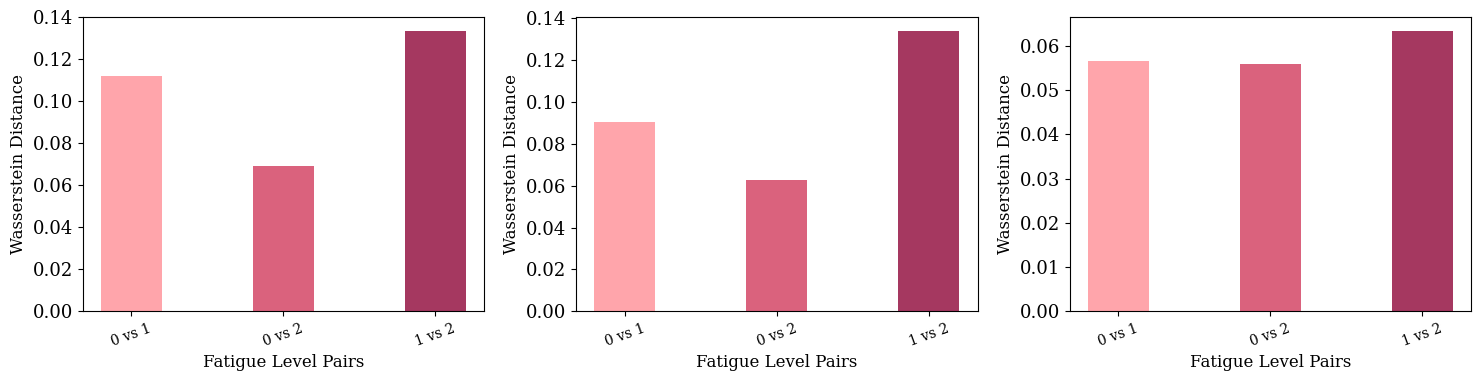

In [381]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wasserstein_distance

def compute_wasserstein_distances_filtered(avg_Dq_results, target_labels=[0, 1, 2]):
    """
    Computes the Wasserstein distance between each pair of Dq distributions for the specified labels only.
    Returns a dictionary with tuple keys representing label pairs and their respective distances.
    """
    available_labels = sorted(set(avg_Dq_results.keys()) & set(target_labels))  # Filter labels
    wasserstein_distances = {}

    for i in range(len(available_labels)):
        for j in range(i + 1, len(available_labels)):  # Avoid duplicate pairs
            label1, label2 = available_labels[i], available_labels[j]
            Dq1 = avg_Dq_results[label1][0].flatten()  # Mean Dq for label1
            Dq2 = avg_Dq_results[label2][0].flatten()  # Mean Dq for label2
            
            distance = wasserstein_distance(Dq1, Dq2)
            wasserstein_distances[(label1, label2)] = distance

    return wasserstein_distances

def plot_wasserstein_bar(ax, wasserstein_results, title):
    """
    Plots a bar chart of Wasserstein distances between fatigue labels on a given subplot.
    """
    pairs = [f"{label1} vs {label2}" for (label1, label2) in wasserstein_results.keys()]
    distances = list(wasserstein_results.values())

    colors = ['#ffa5ab', '#da627d', '#a53860']  # Color scheme

    bars = ax.bar(pairs, distances, color=colors[:len(pairs)], width=0.4)
    
    ax.set_xlabel("Fatigue Level Pairs", fontsize=12)
    ax.set_ylabel("Wasserstein Distance", fontsize=12)
    # ax.set_title(title, fontsize=14)
    ax.set_xticklabels(pairs, ha="center", fontsize=10)
    ax.tick_params(axis='x', rotation=20)

# Define the required channels and sessions
configurations = [
    ("TP9", "Second"),
    ("TP10", "Second"),
    ("TP10", "First")
]

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Load data and process for each channel-session combination
for ax, (channel, session) in zip(axes, configurations):
    eegData, fatigueLabels = loadData(user_id=[str(i) for i in range(20) if i not in (12, 18)], channel=channel, session_day=[session])
    avg_Dq_results = process_eeg_data_all(eegData, fatigueLabels, Dq)
    
    wasserstein_results_filtered = compute_wasserstein_distances_filtered(avg_Dq_results, target_labels=[0, 1, 2])
    plot_wasserstein_bar(ax, wasserstein_results_filtered, title=f"{channel} - {session}")

plt.tight_layout()
plt.savefig("combined_wasserstein_plot.png", dpi=300, bbox_inches='tight')
plt.show()


In [391]:

plt.rcParams.update({
    'font.family': 'serif',  # Options: 'sans-serif', 'serif', 'monospace', etc.
    'font.size': 16,         # Change font size (default is 10)
})

session loaded successfully {'user_id': '0', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '1', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '2', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '3', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '4', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '5', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': 

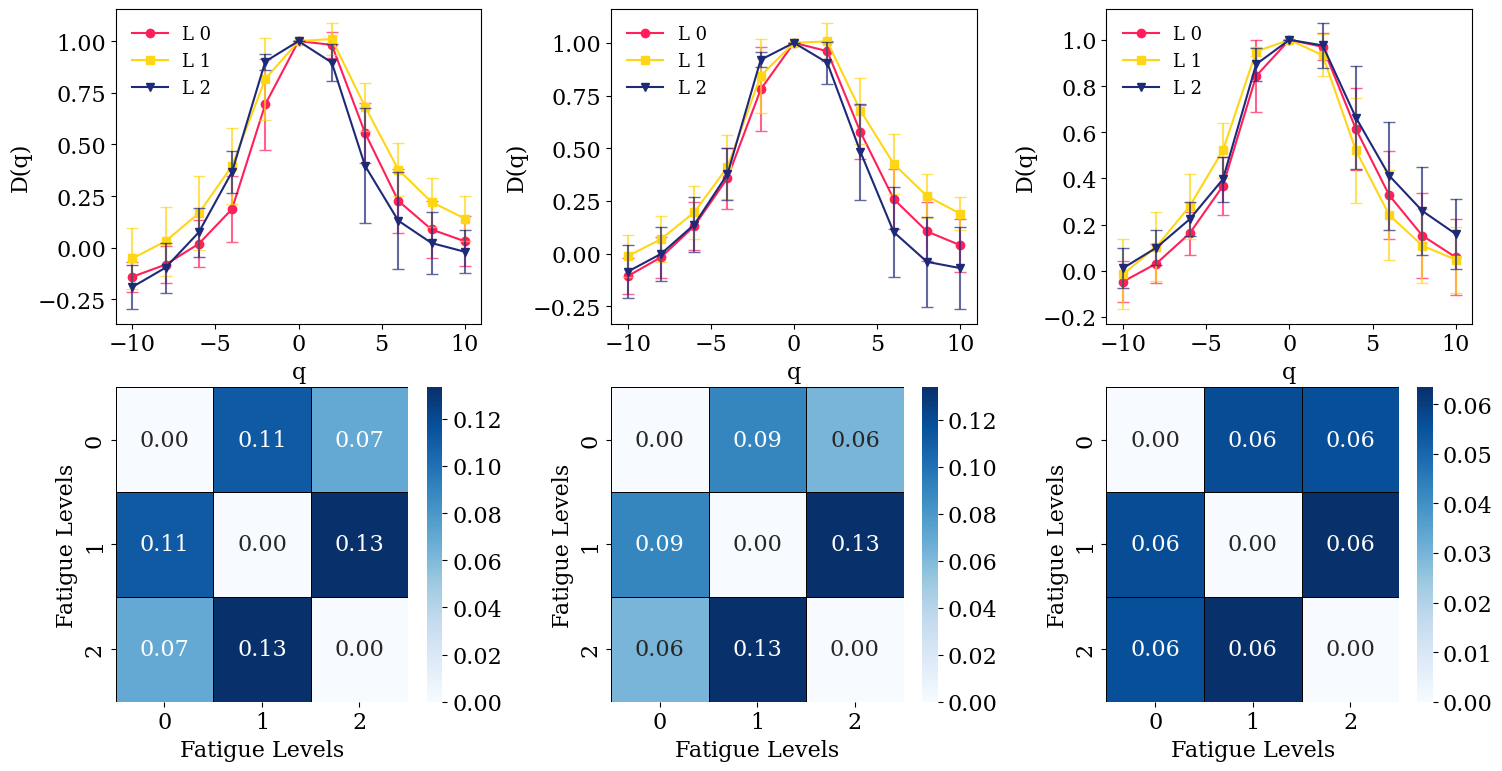

In [408]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import wasserstein_distance

def compute_wasserstein_distances_filtered(avg_Dq_results, target_labels=[0, 1, 2]):
    available_labels = sorted(set(avg_Dq_results.keys()) & set(target_labels))  
    wasserstein_distances = np.zeros((len(available_labels), len(available_labels)))
    
    for i in range(len(available_labels)):
        for j in range(i + 1, len(available_labels)):  
            label1, label2 = available_labels[i], available_labels[j]
            Dq1 = avg_Dq_results[label1][0].flatten()  
            Dq2 = avg_Dq_results[label2][0].flatten()  
            
            distance = wasserstein_distance(Dq1, Dq2)
            wasserstein_distances[i, j] = distance
            wasserstein_distances[j, i] = distance
    
    return available_labels, wasserstein_distances

def plot_Dq_subplot(ax, results, title):
    colors = ['#FF1F5A', '#FFD615', '#1E2A78']
    markers = ['o', 's', 'v']
    
    for i, (label, (mean_Dq, lower_CI, upper_CI, q_values)) in enumerate(results.items()):
        if label < 3:
            q_values_half = q_values[:]
            mean_Dq_half = mean_Dq.flatten()[:]
            ci_range = upper_CI.flatten() - lower_CI.flatten()
            
            ax.plot(q_values_half, mean_Dq_half, 's-', label=f'L {label}', color=colors[i], marker=markers[i])
            ax.errorbar(q_values_half, mean_Dq_half, yerr=ci_range / 2, fmt='none', ecolor=colors[i], capsize=4, capthick=1, alpha=0.7)
    
    ax.set_xlabel('q')
    ax.set_ylabel('D(q)')
    ax.legend(fontsize=13, frameon=False, loc='upper left')

def plot_wasserstein_heatmap(ax, labels, wasserstein_matrix, title):
    sns.heatmap(wasserstein_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax,linewidths=0.5, linecolor='black')
    # ax.set_title(title)
    ax.set_xlabel("Fatigue Levels")
    ax.set_ylabel("Fatigue Levels")


configurations = [
    ("TP9", "Second"),
    ("TP10", "Second"),
    ("TP10", "First")
]


fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for col, (channel, session) in enumerate(configurations):
    eegData, fatigueLabels = loadData(user_id=[str(i) for i in range(20) if i not in (12, 18)], channel=channel, session_day=[session])
    avg_Dq_results = process_eeg_data_all(eegData, fatigueLabels, Dq)
    
    labels, wasserstein_matrix = compute_wasserstein_distances_filtered(avg_Dq_results, target_labels=[0, 1, 2])
    
    plot_Dq_subplot(axes[0, col], avg_Dq_results, title=f"{channel} - {session}")
    
    plot_wasserstein_heatmap(axes[1, col], labels, wasserstein_matrix, title=f"{channel} - {session}")

plt.tight_layout(h_pad=0.2)  # Adjusted h_pad to increase row spacing
plt.savefig("combined_Dq_Wasserstein_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


In [185]:
from scipy.stats import kruskal
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer
from sklearn.utils import resample
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.stats import linregress
from scipy.stats import zscore
from itertools import groupby


#change the root address base on your drive address
# df = pd.read_pickle('/content/drive/MyDrive/ComplexityIndex/data1/Copy_of_processed_data_full.pkl')
df = pd.read_pickle('/Users/athenasaghi/VSProjects/CognitiveFatigueDetection/processed_data_full.pkl')

#df = pd.read_pickle('')
X_raweeg = np.stack(df['raweeg'].values)
X_features = np.stack(df['features'].values)
Y_labels = df['label'].values

# Remove class 3
mask = Y_labels != 3
X_raweeg = X_raweeg[mask]
X_features = X_features[mask]
Y_labels = Y_labels[mask]

num_classes = len(np.unique(Y_labels))
Y_labels = to_categorical(Y_labels, num_classes=num_classes)

# Standardize Data
scaler = StandardScaler()
X_raweeg = scaler.fit_transform(X_raweeg.reshape(-1, X_raweeg.shape[-1])).reshape(X_raweeg.shape)
X_features = scaler.fit_transform(X_features.reshape(-1, X_features.shape[-1])).reshape(X_features.shape)

X_raweeg, X_features, Y_labels = shuffle(X_raweeg, X_features, Y_labels, random_state=42)

def calculate_lzc(binary_sequence):
    n = len(binary_sequence)
    unique_patterns = set()
    i, length, c = 0, 1, 1

    while i + length <= n:
        new_pattern = tuple(binary_sequence[i:i + length])
        if new_pattern not in unique_patterns:
            unique_patterns.add(new_pattern)
            i += length
            length = 1
            c += 1
        else:
            length += 1


    return c / (n / np.log2(n))


def CI(coupling_matrix):

    flat_sequence = coupling_matrix.flatten()


    binary_sequence = (flat_sequence > np.median(flat_sequence)).astype(int)

    # Calculate the Complexity Index using LZC
    return calculate_lzc(binary_sequence)


label_map = {0: 'Non-Fatigue', 1: 'Drowsiness', 2: 'Fatigue'}
for i in range(len(X_features)):
    coupling_matrix = X_features[i]  # Each is a 202 x 16 matrix, 78 samples
    print(f"Sample {i} shape: {coupling_matrix.shape}")

    label_index = np.argmax(Y_labels[i])
    print(f"Label: {label_map[label_index]}")
    complexity_index = CI(coupling_matrix)
    print(f"Complexity Index: {complexity_index}")


lzc_non_fatigue = []
lzc_drowsiness = []
lzc_fatigue = []


label_map = {0: 'Non-Fatigue', 1: 'Drowsiness', 2: 'Fatigue'}
for i in range(len(X_features)):
    coupling_matrix = X_features[i]
    label_index = np.argmax(Y_labels[i])
    complexity_index = CI(coupling_matrix)


    if label_index == 0:
        lzc_non_fatigue.append(complexity_index)
    elif label_index == 1:
        lzc_drowsiness.append(complexity_index)
    elif label_index == 2:
        lzc_fatigue.append(complexity_index)

# Kruskal-Wallis test
statistic, p_value = kruskal(lzc_non_fatigue, lzc_drowsiness, lzc_fatigue)


print("Kruskal-Wallis Test Results:")
print(f"Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")


alpha = 0.05
if p_value < alpha:
    print("The differences in Complexity Index among the three fatigue states are statistically significant.")
else:
    print("No significant difference in Complexity Index among the three fatigue states.")

# Optional: Print mean CI values for each group for reference
print("\nMean Complexity Index Values:")
print(f"Non-Fatigue: {np.mean(lzc_non_fatigue):.4f}")
print(f"Drowsiness: {np.mean(lzc_drowsiness):.4f}")
print(f"Fatigue: {np.mean(lzc_fatigue):.4f}")


Sample 0 shape: (202, 16)
Label: Non-Fatigue
Complexity Index: 1.197563803302474
Sample 1 shape: (202, 16)
Label: Fatigue
Complexity Index: 1.2697062010917797
Sample 2 shape: (202, 16)
Label: Non-Fatigue
Complexity Index: 1.172313964076217
Sample 3 shape: (202, 16)
Label: Non-Fatigue
Complexity Index: 1.0641003673922587
Sample 4 shape: (202, 16)
Label: Fatigue
Complexity Index: 1.183135323744613
Sample 5 shape: (202, 16)
Label: Drowsiness
Complexity Index: 0.9955650894924182
Sample 6 shape: (202, 16)
Label: Non-Fatigue
Complexity Index: 1.1254214055131684
Sample 7 shape: (202, 16)
Label: Drowsiness
Complexity Index: 1.3923482773335993
Sample 8 shape: (202, 16)
Label: Non-Fatigue
Complexity Index: 1.161492604407821
Sample 9 shape: (202, 16)
Label: Non-Fatigue
Complexity Index: 1.2588848414233837
Sample 10 shape: (202, 16)
Label: Drowsiness
Complexity Index: 1.1001715662869114
Sample 11 shape: (202, 16)
Label: Non-Fatigue
Complexity Index: 1.186742443634078
Sample 12 shape: (202, 16)
Lab

In [189]:
print("Length of lzc_non_fatigue:", len(lzc_non_fatigue))
print("Length of lzc_drowsiness:", len(lzc_drowsiness))
print("Length of lzc_fatigue:", len(lzc_fatigue))
print("Length of monofractal_cis:", len(monofractal_cis))

Length of lzc_non_fatigue: 49
Length of lzc_drowsiness: 16
Length of lzc_fatigue: 13
Length of monofractal_cis: 100


In [170]:
!pip install FBM

    PyYAML (>=5.1.*)
            ~~~~~~^


In [186]:
#Parameters
from fbm import FBM
hurst = 0.75
n = 1024
num_signals = 100

monofractal_signals = [FBM(n=n, hurst=hurst).fbm() for _ in range(num_signals)]

monofractal_cis = [CI(signal) for signal in monofractal_signals]


for i, (signal, ci) in enumerate(zip(monofractal_signals, monofractal_cis)):
    print(f"\nSignal {i+1}/{num_signals}:")
    print(f"Signal shape: {signal.shape}")
    print(f"Complexity Index: {ci:.4f}")

print(f"\nAverage LZC for H={hurst}: {np.mean(monofractal_cis):.4f} ± {np.std(monofractal_cis):.4f}")


Signal 1/100:
Signal shape: (1025,)
Complexity Index: 0.7708

Signal 2/100:
Signal shape: (1025,)
Complexity Index: 0.6440

Signal 3/100:
Signal shape: (1025,)
Complexity Index: 0.6440

Signal 4/100:
Signal shape: (1025,)
Complexity Index: 0.6733

Signal 5/100:
Signal shape: (1025,)
Complexity Index: 0.7318

Signal 6/100:
Signal shape: (1025,)
Complexity Index: 0.7123

Signal 7/100:
Signal shape: (1025,)
Complexity Index: 0.6538

Signal 8/100:
Signal shape: (1025,)
Complexity Index: 0.6245

Signal 9/100:
Signal shape: (1025,)
Complexity Index: 0.6440

Signal 10/100:
Signal shape: (1025,)
Complexity Index: 0.6245

Signal 11/100:
Signal shape: (1025,)
Complexity Index: 0.7513

Signal 12/100:
Signal shape: (1025,)
Complexity Index: 0.7708

Signal 13/100:
Signal shape: (1025,)
Complexity Index: 0.7123

Signal 14/100:
Signal shape: (1025,)
Complexity Index: 0.6830

Signal 15/100:
Signal shape: (1025,)
Complexity Index: 0.7221

Signal 16/100:
Signal shape: (1025,)
Complexity Index: 0.6830



In [187]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde, wasserstein_distance

#

session loaded successfully {'user_id': '0', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '1', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '2', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '3', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '4', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '5', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': 

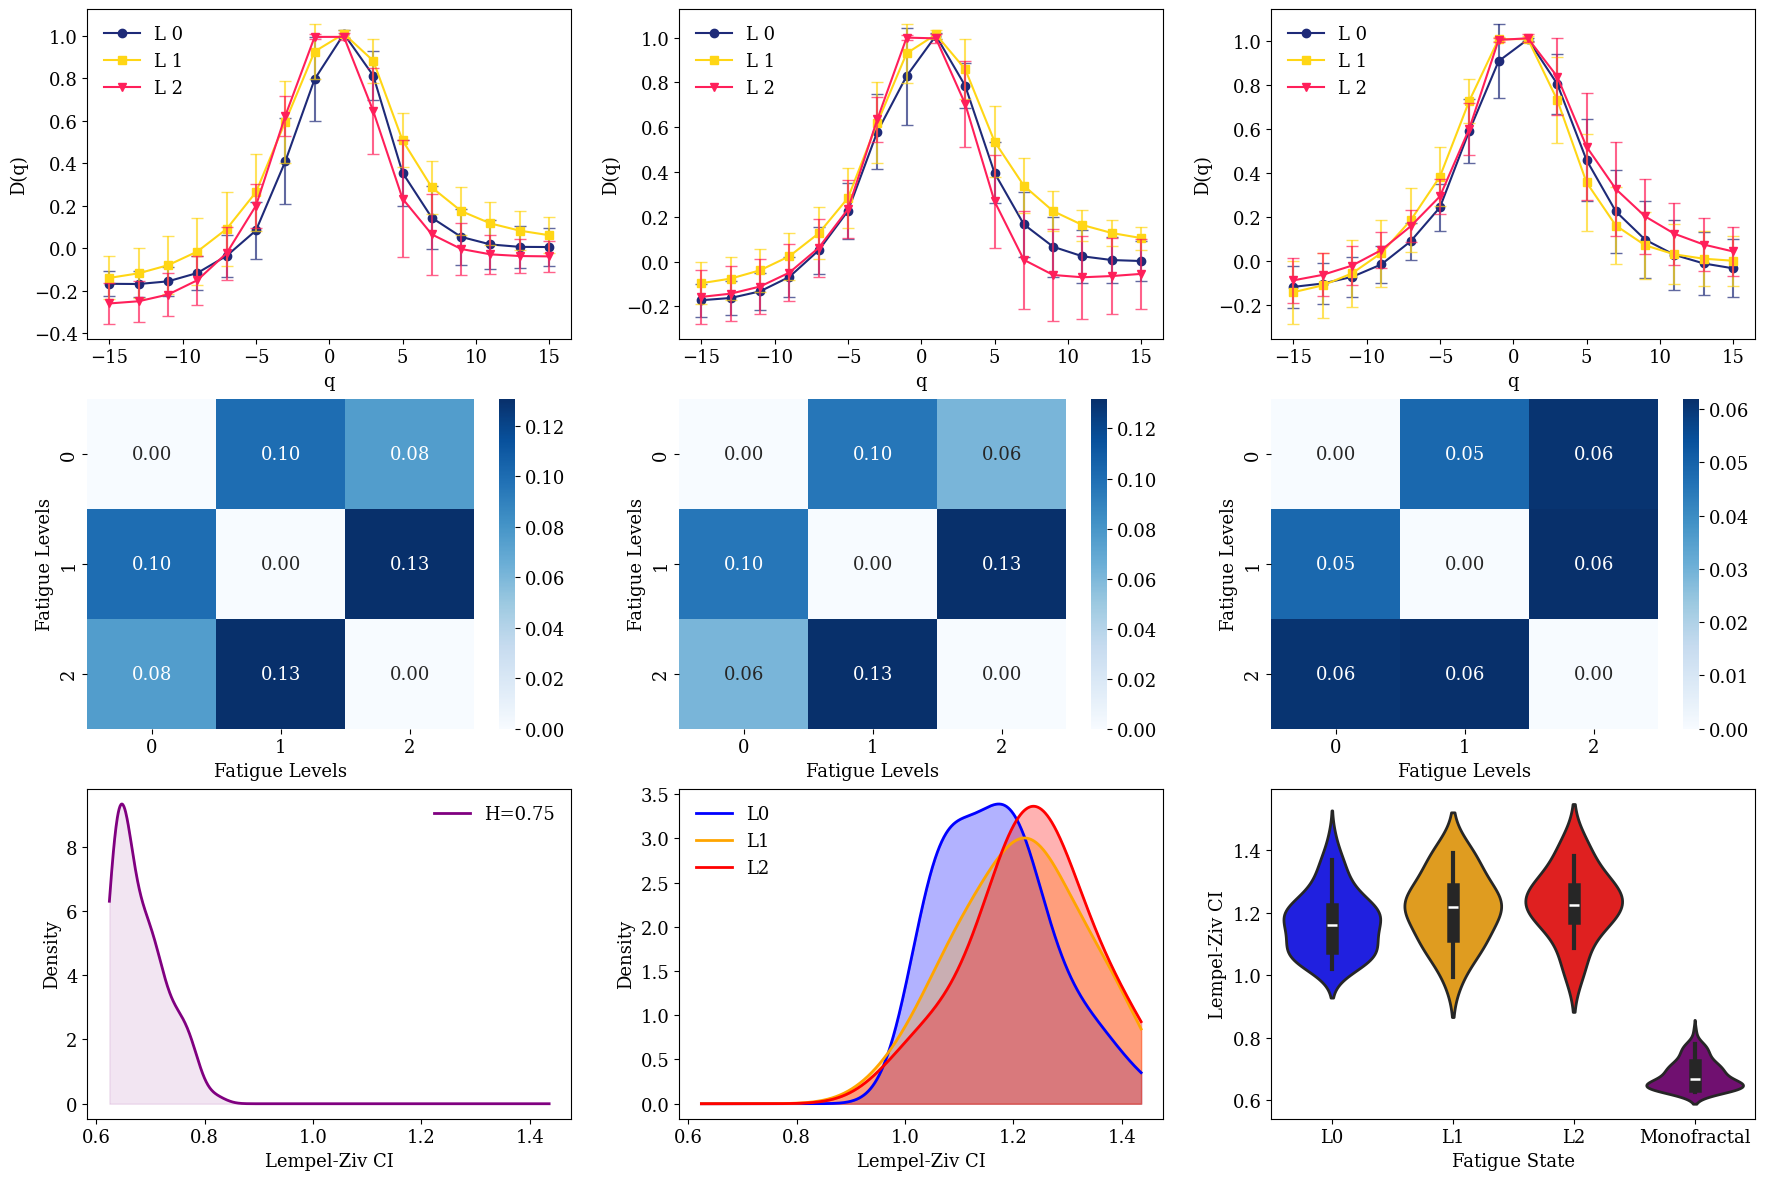

In [191]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde, wasserstein_distance

def compute_wasserstein_distances_filtered(avg_Dq_results, target_labels=[0, 1, 2]):
    available_labels = sorted(set(avg_Dq_results.keys()) & set(target_labels))  
    wasserstein_distances = np.zeros((len(available_labels), len(available_labels)))
    
    for i in range(len(available_labels)):
        for j in range(i + 1, len(available_labels)):  
            label1, label2 = available_labels[i], available_labels[j]
            Dq1 = avg_Dq_results[label1][0].flatten()  
            Dq2 = avg_Dq_results[label2][0].flatten()  
            
            distance = wasserstein_distance(Dq1, Dq2)
            wasserstein_distances[i, j] = distance
            wasserstein_distances[j, i] = distance
    
    return available_labels, wasserstein_distances

def plot_Dq_subplot(ax, results, title):
    colors = ['#1E2A78', '#FFD615', '#FF1F5A']
    markers = ['o', 's', 'v']
    
    for i, (label, (mean_Dq, lower_CI, upper_CI, q_values)) in enumerate(results.items()):
        if label < 3:
            q_values_half = q_values[:]
            mean_Dq_half = mean_Dq.flatten()[:]
            ci_range = upper_CI.flatten() - lower_CI.flatten()
            
            ax.plot(q_values_half, mean_Dq_half, linestyle='-', marker=markers[i], label=f'L {label}', color=colors[i])
            ax.errorbar(q_values_half, mean_Dq_half, yerr=ci_range / 2, fmt='none', ecolor=colors[i], capsize=4, capthick=1, alpha=0.7)
    
    ax.set_xlabel('q')
    ax.set_ylabel('D(q)')
    ax.legend(fontsize=13, frameon=False, loc='upper left')

def plot_wasserstein_heatmap(ax, labels, wasserstein_matrix, title):
    sns.heatmap(wasserstein_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Fatigue Levels")
    ax.set_ylabel("Fatigue Levels")


# ---- Configuration ----
configurations = [
    ("TP9", "Second"),
    ("TP10", "Second"),
    ("TP10", "First")
]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))  # 3 rows now

for col, (channel, session) in enumerate(configurations):
    # Replace this with your actual data loading
    eegData, fatigueLabels = loadData(
        user_id=[str(i) for i in range(20) if i not in (12, 18)],
        channel=channel,
        session_day=[session]
    )
    avg_Dq_results = process_eeg_data_all(eegData, fatigueLabels, Dq)
    
    labels, wasserstein_matrix = compute_wasserstein_distances_filtered(avg_Dq_results, target_labels=[0, 1, 2])
    

    plot_Dq_subplot(axes[0, col], avg_Dq_results, title=f"{channel} - {session}")
    

    plot_wasserstein_heatmap(axes[1, col], labels, wasserstein_matrix, title=f"{channel} - {session}")

x_range_all = np.linspace(
    min(np.min(lzc_non_fatigue), np.min(lzc_drowsiness), np.min(lzc_fatigue), np.min(monofractal_cis)),
    max(np.max(lzc_non_fatigue), np.max(lzc_drowsiness), np.max(lzc_fatigue), np.max(monofractal_cis)),
    1000
)

# Column 0: Monofractal KDE
ax = axes[2, 0]
kde = gaussian_kde(monofractal_cis, bw_method='silverman')
y = kde(x_range_all)
ax.plot(x_range_all, y, color='purple', linewidth=2, label=f'H={0.75}')
ax.fill_between(x_range_all, y, color='purple', alpha=0.1)
ax.set_xlabel("Lempel-Ziv CI")
ax.set_ylabel("Density")
# ax.set_title("Monofractal Density")
# ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(frameon=False)

# Column 1: Levels KDE
ax = axes[2, 1]
colors = ['blue', 'orange', 'red', 'purple']
labels_kde = ['L0', 'L1', 'L2', 'Monofractal']
datasets = [lzc_non_fatigue, lzc_drowsiness, lzc_fatigue, monofractal_cis]

for data, color, label in zip(datasets, colors, labels_kde):
    if label == 'Monofractal':
        continue
    kde = gaussian_kde(np.asarray(data, dtype=float), bw_method='silverman')
    y = kde(x_range_all)
    ax.plot(x_range_all, y, color=color, linewidth=2, label=label)
    ax.fill_between(x_range_all, y, color=color, alpha=0.3 if label != 'Monofractal' else 0.1)

ax.set_xlabel("Lempel-Ziv CI")
ax.set_ylabel("Density")
# ax.set_title("CI Levels Density")
# ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(frameon=False)

# Column 2: Violin Plot
ax = axes[2, 2]
all_ci_values = np.hstack([lzc_non_fatigue, lzc_drowsiness, lzc_fatigue, monofractal_cis])
data = pd.DataFrame({
    'Category': (
        ['L0'] * len(lzc_non_fatigue) +
        ['L1'] * len(lzc_drowsiness) +
        ['L2'] * len(lzc_fatigue) +
        ['Monofractal'] * len(monofractal_cis)
    ),
    'Complexity Index': all_ci_values
})
sns.violinplot(
    x='Category',
    y='Complexity Index',
    data=data,
    order=labels_kde,
    hue='Category',
    palette=colors,
    inner="box",
    linewidth=2,
    ax=ax,
    legend=False
)
ax.set_xlabel("Fatigue State")
ax.set_ylabel("Lempel-Ziv CI")
# ax.set_title("CI Distribution (Violin)")
# ax.grid(axis='y', linestyle='--', alpha=0.7)

# ---- Finalize ----
plt.tight_layout(h_pad=0.5)
plt.savefig("combined_plot_with_CI.png", dpi=300, bbox_inches='tight')
plt.show()


session loaded successfully {'user_id': '0', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '1', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '2', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '3', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '4', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': '5', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'Second', 'wcst_version': 'V2'} size of the session data 128
session loaded successfully {'user_id': 

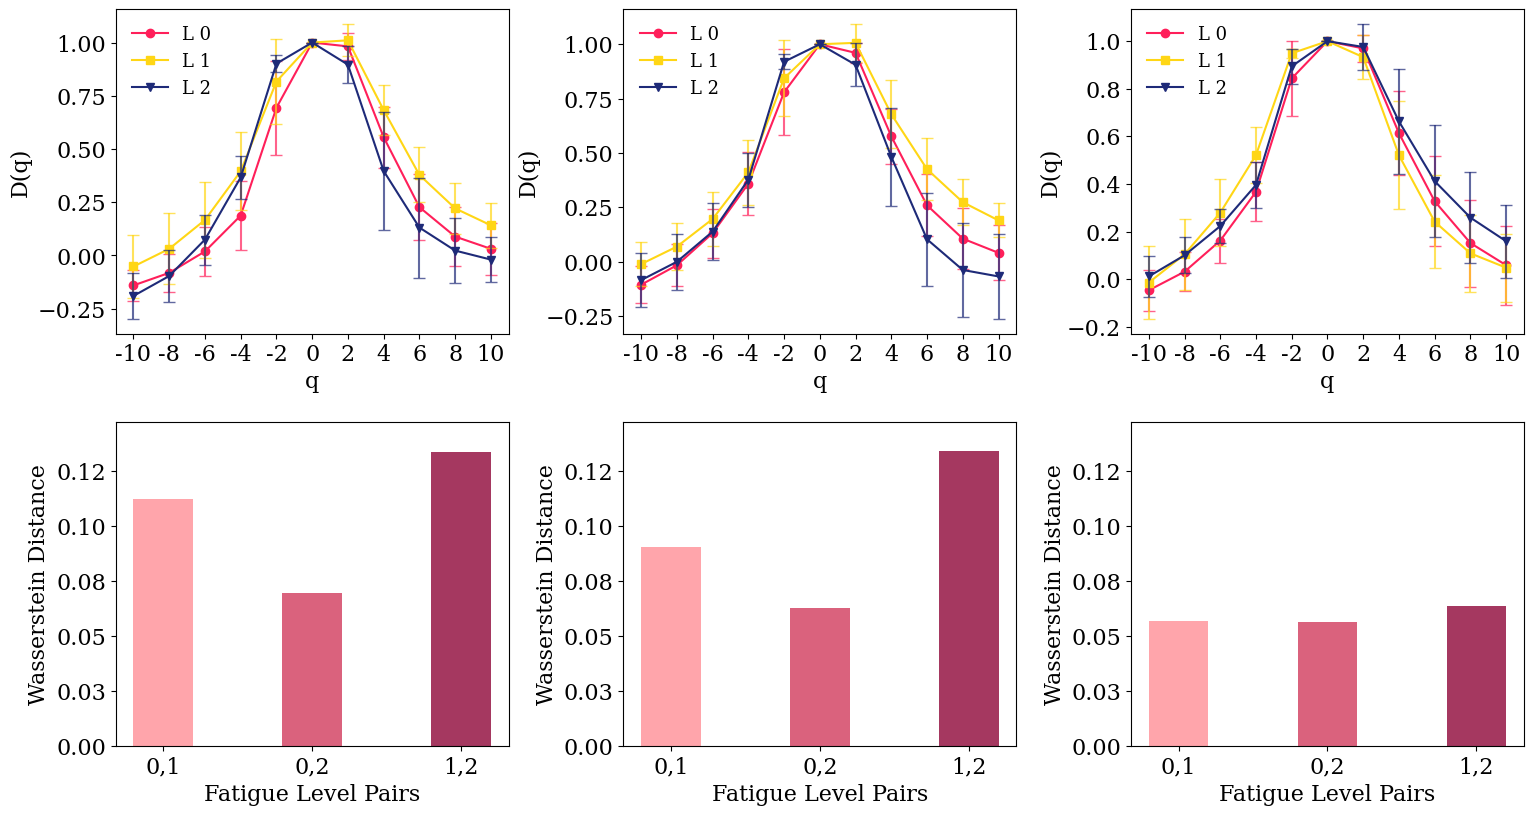

In [400]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wasserstein_distance
import matplotlib.ticker as mticker


def compute_wasserstein_distances_filtered(avg_Dq_results, target_labels=[0, 1, 2]):
    available_labels = sorted(set(avg_Dq_results.keys()) & set(target_labels))  
    wasserstein_distances = {}

    for i in range(len(available_labels)):
        for j in range(i + 1, len(available_labels)):  
            label1, label2 = available_labels[i], available_labels[j]
            Dq1 = avg_Dq_results[label1][0].flatten()  
            Dq2 = avg_Dq_results[label2][0].flatten()  
            
            distance = wasserstein_distance(Dq1, Dq2)
            wasserstein_distances[(label1, label2)] = distance

    return wasserstein_distances

def plot_Dq_subplot(ax, results, title):
    colors = ['#FF1F5A', '#FFD615', '#1E2A78']
    markers = ['o', 's', 'v', 'x', 'd', '^', 'p', 'h', '+']
    
    for i, (label, (mean_Dq, lower_CI, upper_CI, q_values)) in enumerate(results.items()):
        if label < 3:
            half_idx = 0
            q_values_half = q_values[half_idx:]
            mean_Dq_half = mean_Dq.reshape(-1)[half_idx:]
            lower_CI_half = lower_CI.reshape(-1)[half_idx:]
            upper_CI_half = upper_CI.reshape(-1)[half_idx:]
            ci_range = upper_CI_half - lower_CI_half
            
            ax.plot(q_values_half, mean_Dq_half, 's-', label=f'L {label}', color=colors[i], marker=markers[i])
            ax.errorbar(q_values_half, mean_Dq_half, yerr=ci_range / 2, fmt='none', ecolor=colors[i], capsize=4, capthick=1, alpha=0.7)
    
    ax.set_xlabel('q')
    ax.set_ylabel('D(q)')
    ax.set_xticks(q_values_half)
    ax.set_xticklabels([str(q) for q in q_values_half])
    ax.legend(fontsize = 13,frameon=False, loc='upper left')

def plot_wasserstein_bar(ax, wasserstein_results, title, y_max):
    pairs = [f"{label1},{label2}" for (label1, label2) in wasserstein_results.keys()]
    distances = list(wasserstein_results.values())

    colors = ['#ffa5ab', '#da627d', '#a53860']  

    bars = ax.bar(pairs, distances, color=colors[:len(pairs)], width=0.4)
    
    ax.set_xlabel("Fatigue Level Pairs")
    ax.set_ylabel("Wasserstein Distance")
    ax.set_xticks(range(len(pairs)))
    ax.set_xticklabels(pairs, ha="center")
    ax.tick_params(axis='x', rotation=0)

    # Set uniform y-axis range
    ax.set_ylim(0, y_max * 1.1)  # Add 10% margin to max value
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# Define required channels and sessions
configurations = [
    ("TP9", "Second"),
    ("TP10", "Second"),
    ("TP10", "First")
]

# Create a figure with 2 rows and 3 columns (1st row → Dq plots, 2nd row → Wasserstein bar plots)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Store max Wasserstein distance for y-axis normalization
global_y_max = 0

# First pass: Process data and find global y_max for the bar plots
all_wasserstein_results = []
for channel, session in configurations:
    eegData, fatigueLabels = loadData(user_id=[str(i) for i in range(20) if i not in (12, 18)], channel=channel, session_day=[session])
    avg_Dq_results = process_eeg_data_all(eegData, fatigueLabels, Dq)
    
    wasserstein_results_filtered = compute_wasserstein_distances_filtered(avg_Dq_results, target_labels=[0, 1, 2])
    all_wasserstein_results.append(wasserstein_results_filtered)

    # Update global max for y-axis scaling
    if wasserstein_results_filtered:
        max_value = max(wasserstein_results_filtered.values())
        global_y_max = max(global_y_max, max_value)

# Second pass: Generate plots with fixed y-axis
for col, ((channel, session), wasserstein_results_filtered) in enumerate(zip(configurations, all_wasserstein_results)):
    eegData, fatigueLabels = loadData(user_id=[str(i) for i in range(20) if i not in (12, 18)], channel=channel, session_day=[session])
    avg_Dq_results = process_eeg_data_all(eegData, fatigueLabels, Dq)
    
    # Plot Dq in first row
    plot_Dq_subplot(axes[0, col], avg_Dq_results, title=f"{channel} - {session}")
    
    # Plot Wasserstein distance in second row with fixed y-axis
    plot_wasserstein_bar(axes[1, col], wasserstein_results_filtered, title=f"{channel} - {session}", y_max=global_y_max)

# Minimize spacing & save image with minimal margins
# plt.margins(0)
plt.tight_layout(pad=0.1, h_pad=1.3, w_pad=0.4)  # Adjusted h_pad to increase row spacing
plt.savefig("combined_Dq_Wasserstein_plot_fixed.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
# import numpy as np
# import collections
# from decimal import Decimal, getcontext
# from scipy.integrate import trapezoid

# # Set Decimal precision for high accuracy
# getcontext().prec = 50  

# def entropy(probabilities, order=1):
#     """Computes Rényi entropy using Decimal precision."""
#     probabilities = [Decimal(p) for p in probabilities if p > 0]

#     if order == 1:
#         return sum(p * p.ln() for p in probabilities)
    
#     order = int(order)  # Ensure order is a standard Python int
#     return (sum(p ** order for p in probabilities)).ln() / Decimal(order - 1)

# def spectrum(signal, powers=np.arange(-10, 11), scales=None):
#     """Computes the multifractal spectrum for a 1D signal."""
    
#     if scales is None:
#         scales = np.pi / 2 ** np.arange(5)

#     sorted_signal = np.sort(signal) - np.min(signal)
#     result = []

#     for scale in scales:
#         bins = np.floor(sorted_signal / scale)
#         counts = collections.Counter(bins).values()
#         counts = np.array([Decimal(c) for c in counts])
#         probs = counts / sum(counts)
#         result.append(probs)

#     x = np.log(scales)
#     powers = np.array([int(q) for q in powers])  # Convert NumPy int to Python int
#     slopes = []

#     for q in powers:
#         y = np.array([entropy(r, q) for r in result], dtype=np.float64)
#         A = np.vstack([x, np.ones_like(x)]).T
#         fit = np.linalg.lstsq(A, y, rcond=None)[0]
#         slopes.append(fit[0])

#     dq = np.array(slopes)
#     a = np.gradient((powers - 1) * dq, edge_order=2)
#     f = a * powers - (powers - 1) * dq

#     return a, f, dq


In [ ]:

# def process_eeg_data_all2(eegData, fatigueLabels, function_f):
#     fatigue_grouped_A = {}
#     fatigue_grouped_dq = {}
#     for participant_eeg, participant_labels in zip(eegData, fatigueLabels):
#         label_groups = {}
#         for eeg_segment, label in zip(participant_eeg, participant_labels):
#             if label not in label_groups:
#                 label_groups[label] = []
#             label_groups[label].append(eeg_segment)

#         # Compute Dq for each label
#         for label, data_group in label_groups.items():
#             a,f,dq = function_f(np.concatenate(data_group))
#             if label not in fatigue_grouped_dq:
#                 fatigue_grouped_dq[label] = []
#             if label not in fatigue_grouped_A:
#                 fatigue_grouped_A[label] = []
#             fatigue_grouped_A[label].append(a)
#             fatigue_grouped_dq[label].append(dq)



#     return fatigue_grouped_A,fatigue_grouped_dq

# A, dq = process_eeg_data_all2(eegData, fatigueLabels, spectrum)

In [415]:
import os
import pandas as pd
import numpy as np
from collections import Counter

def get_filtered_distribution_per_file(path):
    distributions = {}
    for filename in os.listdir(path):
        if filename.endswith('.csv'):
            file_path = os.path.join(path, filename)
            df = pd.read_csv(file_path)
            numeric_data = df.select_dtypes(include=[np.number]).values.flatten()
            unique, counts = np.unique(numeric_data[~np.isnan(numeric_data)], return_counts=True)
            filtered = {k: v for k, v in zip(unique, counts) if k > 2}
            if filtered:
                distributions[filename] = filtered
    return distributions


In [416]:
path = '/Users/athenasaghi/VSProjects/CognitiveFatigueDetection/CogFatigueData/CogBeacon/fatigue_self_report'
filtered_distributions = get_filtered_distribution_per_file(path)

for file, dist in filtered_distributions.items():
    print(f"{file}: {dist}")

user_3_v_m.csv: {3: 26, 4: 20, 5: 7, 6: 18}
user_6b_v_m.csv: {3: 14}
user_14b_v_m.csv: {3: 29}
user_2_v_m.csv: {3: 16}
user_0_v_m.csv: {3: 42, 4: 32}
user_1_v_m.csv: {3: 14}
user_19b_v_m.csv: {3: 31, 4: 31, 5: 18}
user_1b_v_m.csv: {3: 29}
user_0b_v_m.csv: {3: 13}
user_2b_v_m.csv: {3: 58, 4: 25}
user_3b_v_m.csv: {3: 46, 4: 20}
user_11b_v_m.csv: {3: 3}
